# 10_Model: Xtreme Gradient Boost with only extracted features:

- Complexity
- Lexical / stylometric features

In [2]:
import pandas as pd

df = pd.read_csv('../data/spanish_corpus_features_v4.csv')
pd.options.display.max_columns = None
df.head()

,text,headline,words_h,avg_word_size_h,unique_words_h,ttr_h,mltd_h,sents,words,avg_words_sents,avg_word_size,unique_words,ttr,mltd,entity_ratio,n_quotes,quotes_ratio,propn_ratio,noun_ratio,adp_ratio,det_ratio,punct_ratio,pron_ratio,verb_ratio,adv_ratio,sym_ratio,label
0,sofía castro y alejandro peña pretelini: una i...,sofía castro y alejandro peña pretelini: una i...,12,5.58,100.00,100.00,0.00,6,244,40.67,4.30,36.07,50.82,55.73,7.38,0,0.00,15.57,15.98,14.34,11.89,9.02,5.74,6.56,3.28,0.00,1
1,un paso más cerca de hacer los exámenes 'onlin...,un paso más cerca de hacer los exámenes 'online',11,3.64,81.82,90.91,33.88,9,462,51.33,4.42,34.42,46.10,44.90,9.52,4,0.87,16.67,17.10,12.99,11.69,18.83,1.30,3.46,1.73,1.30,1
2,esto es lo que los científicos realmente piens...,esto es lo que los científicos realmente piens...,12,4.83,83.33,91.67,40.32,29,956,32.97,4.91,26.67,39.33,78.16,2.93,39,4.08,4.81,18.62,14.33,13.08,11.72,2.62,10.56,4.81,0.21,1
3,inicia impresión de boletas para elección pres...,inicia impresión de boletas para elección pres...,7,6.86,100.00,100.00,0.00,10,347,34.70,4.97,24.21,39.19,54.51,2.88,4,1.15,4.32,25.94,19.31,16.14,9.80,2.88,7.78,0.29,0.00,1
4,a número día del mundial fifa.com sigue la cue...,a número día del mundial,5,4.00,100.00,100.00,0.00,4,117,29.25,4.85,53.85,64.96,55.90,8.55,0,0.00,11.11,19.66,19.66,15.38,6.84,3.42,4.27,1.71,0.00,1


In [3]:
df.shape

(971, 27)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             971 non-null    object 
 1   headline         971 non-null    object 
 2   words_h          971 non-null    int64  
 3   avg_word_size_h  971 non-null    float64
 4   unique_words_h   971 non-null    float64
 5   ttr_h            971 non-null    float64
 6   mltd_h           971 non-null    float64
 7   sents            971 non-null    int64  
 8   words            971 non-null    int64  
 9   avg_words_sents  971 non-null    float64
 10  avg_word_size    971 non-null    float64
 11  unique_words     971 non-null    float64
 12  ttr              971 non-null    float64
 13  mltd             971 non-null    float64
 14  entity_ratio     971 non-null    float64
 15  n_quotes         971 non-null    int64  
 16  quotes_ratio     971 non-null    float64
 17  propn_ratio     

In [5]:
df.columns

Index(['text', 'headline', 'words_h', 'avg_word_size_h', 'unique_words_h',
       'ttr_h', 'mltd_h', 'sents', 'words', 'avg_words_sents', 'avg_word_size',
       'unique_words', 'ttr', 'mltd', 'entity_ratio', 'n_quotes',
       'quotes_ratio', 'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio',
       'punct_ratio', 'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio',
       'label'],
      dtype='object')

## Grid search

In [6]:
%%time

import pandas as pd
import numpy as np

from scipy import stats
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v4.csv')
y = df['label']

########### Combine features & train, test split ########### 

numerical_features = ['words_h', 'avg_word_size_h', 'unique_words_h',
       'ttr_h', 'mltd_h', 'sents', 'words', 'avg_words_sents', 'avg_word_size',
       'unique_words', 'ttr', 'mltd', 'entity_ratio', 'n_quotes',
       'quotes_ratio', 'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio',
       'punct_ratio', 'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio']

X = df[numerical_features].values
feature_names = df[numerical_features].columns.tolist()

# Calculating level of imbalance for modelling
imbalance_weight = y.value_counts(normalize = True)[0] / y.value_counts(normalize = True)[1]

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)


########### XGB GRID SEARCH ########### 

xgb_model = XGBClassifier(eval_metric = 'auc', objective = 'binary:logistic', nthread = 1, seed = 43, 
                    scale_pos_weight = imbalance_weight)

xgb_params = {'learning_rate': [0.01, 0.02, 0.03],
              'n_estimators': [200, 400, 800, 1000, 1200],
              'max_depth': [2, 4, 6, 8], 
              'subsample': [0.2, 0.3, 0.4], 
              'colsample_bytree': [0.2, 0.5],
              'min_child_weight' : [0.5, 1, 2, 3],
              'lambda': [0.5, 1, 1.5],
              'alpha': [0, 0.2, 0.4]}

folds = 3
skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 43)
grid_search = GridSearchCV(estimator = xgb_model, param_grid = xgb_params, 
                                   scoring = 'roc_auc', n_jobs = 4, cv = skf.split(X_train, y_train), verbose = 3)

grid_search.fit(X_train, y_train)

########### Grid search results ###########
print('\n Best estimator:')
print(grid_search.best_estimator_)
best_estimator = grid_search.best_estimator_

print('\n Best score:')
print(grid_search.best_score_ * 2 - 1)

print('\n Best parameters:')
print(grid_search.best_params_)

Fitting 3 folds for each of 12960 candidates, totalling 38880 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    7.4s


KeyboardInterrupt: 

## Full model

In /home/pipe11/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pipe11/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pipe11/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/pipe11/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pipe11/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

Testing AUC: 0.873521


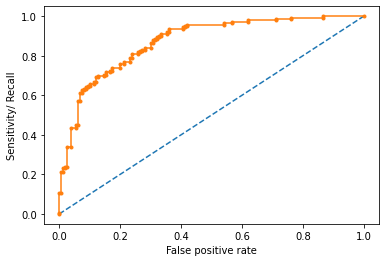

Logloss: 7.81
Accuracy: 77.40


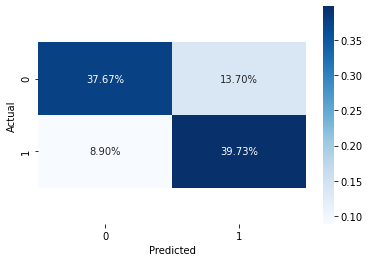

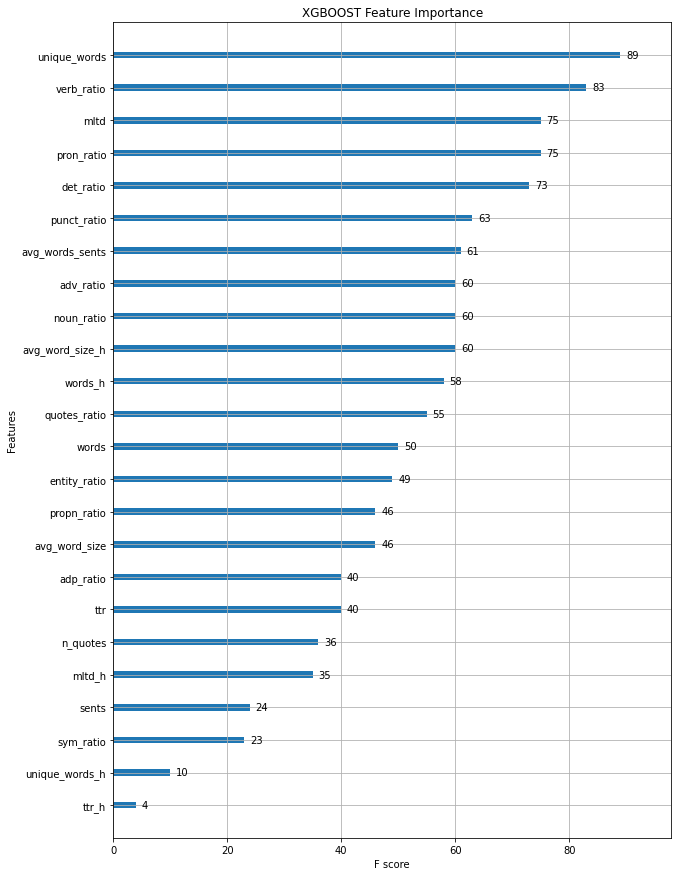

In [7]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v4.csv')
y = df['label']

########### Training and testing split ########### 

numerical_features = ['words_h', 'avg_word_size_h', 'unique_words_h',
       'ttr_h', 'mltd_h', 'sents', 'words', 'avg_words_sents', 'avg_word_size',
       'unique_words', 'ttr', 'mltd', 'entity_ratio', 'n_quotes',
       'quotes_ratio', 'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio',
       'punct_ratio', 'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio']

X = df[numerical_features]
tfvocab = df[numerical_features].columns.tolist()

# Calculating level of imbalance for modelling
imbalance_weight = y.value_counts(normalize = True)[0] / y.value_counts(normalize = True)[1]

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)


########### XGB CLassifier ########### 

xgb_model = XGBClassifier(eval_metric = 'auc', objective = 'binary:logistic', nthread = 1, seed = 43, 
                    scale_pos_weight = imbalance_weight)

xgb_params = {'alpha': 0.4, 
              'colsample_bytree': 0.2, 
              'lambda': 0.5, 
              'learning_rate': 0.03, 
              'max_depth': 4, 
              'min_child_weight': 3, 
              'n_estimators': 200, 
              'subsample': 0.3}

xgb_model.fit(X_train, y_train)


########### Predictions and results ###########

# predictions
y_pred = xgb_model.predict(X_test)
probs = xgb_model.predict_proba(X_test)
probs = probs[:, 1]

# testing AUC
auc = roc_auc_score(y_test, probs)
print('Testing AUC: %f' % auc)

# roc curve calculation
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)

# plot the limits for no skill
plt.plot([0, 1], [0, 1], linestyle = '--')

# plot the roc curve

plt.plot(false_positive_rate, true_positive_rate, marker = '.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
plt.show();

# accuracy score
print('Logloss: %.2f' % (log_loss(y_test, y_pred)))
print('Accuracy: %.2f' % (xgb_model.score(X_test, y_test) * 100))

# confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, labels = [0, 1])
ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot = True, fmt = '.2%', cmap = 'Blues')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show();


########### Feature importance ###########

dict_features = dict(enumerate(tfvocab))

# feature importance with default names

f, ax = plt.subplots(figsize = [10, 15])
axsub = xgb.plot_importance(xgb_model, ax = ax)

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
dict_features = dict(enumerate(tfvocab))
list_yticklabels = [Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]

# feature importance
plt.title("XGBOOST Feature Importance")
axsub.set_yticklabels(list_yticklabels)
plt.show()

## Save the model

In [64]:
import pickle
pickle.dump(xgb_model , open('../predictors/fake_news_predictorv2.pkl', 'wb'))

In [65]:
model = pickle.load(open('../predictors/fake_news_predictorv2.pkl', 'rb'))
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=43, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.9775967413441956, seed=43, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)